In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Let's load the dataset and take a quick look at its structure.
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)
print("Data shape:", df.shape)
display(df.head())
print("Columns in your file:", df.columns.tolist())

Saving cleaned_match_winner.csv to cleaned_match_winner (5).csv
Data shape: (9380, 23)


,match_id,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,home_form,home_avg_gf,...,away_form,away_avg_gf,away_avg_ga,away_h2h,away_h2h_prev_meetings,month,day_of_week,result_label,home_team_enc,away_team_enc
0,0,2000/01,2000-08-19,Charlton,Man City,4,0,H,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,0,12,26
1,1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,0,13,43
2,2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,2,14,28
3,3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,1,16,36
4,4,2000/01,2000-08-19,Leeds,Everton,2,0,H,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,0,22,17


Columns in your file: ['match_id', 'Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult', 'home_form', 'home_avg_gf', 'home_avg_ga', 'home_h2h', 'home_h2h_prev_meetings', 'away_form', 'away_avg_gf', 'away_avg_ga', 'away_h2h', 'away_h2h_prev_meetings', 'month', 'day_of_week', 'result_label', 'home_team_enc', 'away_team_enc']


In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
# We'll extract month and weekday from the match date for some extra features.
df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
df['Month'] = df['MatchDate'].dt.month
df['Weekday'] = df['MatchDate'].dt.weekday


In [ ]:
# Here, I'm encoding the team and season names, making them easy for the models to handle.
team_le = LabelEncoder()
df['HomeTeam_enc'] = team_le.fit_transform(df['HomeTeam'])
df['AwayTeam_enc'] = team_le.fit_transform(df['AwayTeam'])
season_le = LabelEncoder()
df['Season_enc'] = season_le.fit_transform(df['Season'])

In [ ]:
#selecting only the columns that are safe for training, dropping anything that leaks match results.
drop_cols = [
    'match_id',
    'FullTimeHomeGoals', 'FullTimeAwayGoals',
    'FullTimeResult',
    'result_label',
    'HomeTeam', 'AwayTeam', 'Season', 'MatchDate'
]
features = [col for col in df.columns if col not in drop_cols]
print("Final features used:", features)

Final features used: ['home_form', 'home_avg_gf', 'home_avg_ga', 'home_h2h', 'home_h2h_prev_meetings', 'away_form', 'away_avg_gf', 'away_avg_ga', 'away_h2h', 'away_h2h_prev_meetings', 'month', 'day_of_week', 'home_team_enc', 'away_team_enc', 'Month', 'Weekday', 'HomeTeam_enc', 'AwayTeam_enc', 'Season_enc']


In [ ]:
le = LabelEncoder()
y = le.fit_transform(df['FullTimeResult'])



In [ ]:
# Let's build our feature matrix with all the relevant columns.
X = df[features]

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# I'm going to train three different models to see which one does best.
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "model": model,
        "accuracy": acc,
        "report": classification_report(y_test, y_pred, target_names=le.classes_),
        "cm": confusion_matrix(y_test, y_pred)
    }
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", results[name]["cm"])


Decision Tree Accuracy: 0.3955
              precision    recall  f1-score   support

           A       0.39      0.40      0.40       554
           D       0.22      0.22      0.22       462
           H       0.50      0.48      0.49       860

    accuracy                           0.40      1876
   macro avg       0.37      0.37      0.37      1876
weighted avg       0.40      0.40      0.40      1876

Confusion Matrix:
 [[223 135 196]
 [135 102 225]
 [207 236 417]]

Random Forest Accuracy: 0.5053
              precision    recall  f1-score   support

           A       0.48      0.43      0.46       554
           D       0.28      0.12      0.17       462
           H       0.55      0.76      0.64       860

    accuracy                           0.51      1876
   macro avg       0.44      0.44      0.42      1876
weighted avg       0.47      0.51      0.47      1876

Confusion Matrix:
 [[240  60 254]
 [130  55 277]
 [129  78 653]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:10:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.4845
              precision    recall  f1-score   support

           A       0.46      0.43      0.44       554
           D       0.28      0.17      0.21       462
           H       0.55      0.69      0.61       860

    accuracy                           0.48      1876
   macro avg       0.43      0.43      0.42      1876
weighted avg       0.46      0.48      0.46      1876

Confusion Matrix:
 [[236  84 234]
 [132  80 250]
 [143 124 593]]


/tmp/ipython-input-3826378106.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_df.index, y=acc_df["Accuracy"], palette='viridis')


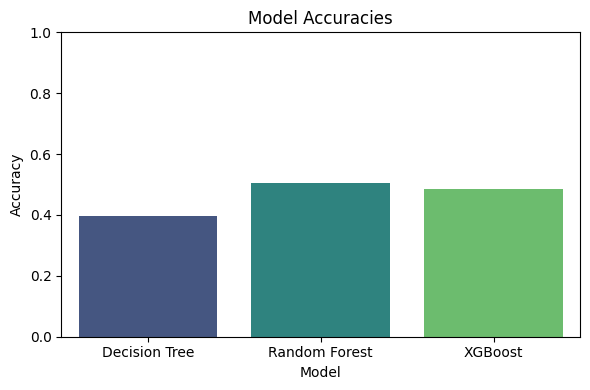

In [ ]:
# Let's visualize the accuracy of each model to compare their performance
acc_df = pd.DataFrame({k: v["accuracy"] for k, v in results.items()}, index=["Accuracy"]).T
plt.figure(figsize=(6,4))
sns.barplot(x=acc_df.index, y=acc_df["Accuracy"], palette='viridis')
plt.title("Model Accuracies")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [ ]:
# We'll select the best performing model and use it for further analysis.
best_model_name = max(results, key=lambda k: results[k]["accuracy"])
best_model = results[best_model_name]["model"]
print(f"\nBest model: {best_model_name} with Accuracy {results[best_model_name]['accuracy']:.4f}")


Best model: Random Forest with Accuracy 0.5053


/tmp/ipython-input-1979848458.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='Blues_r')


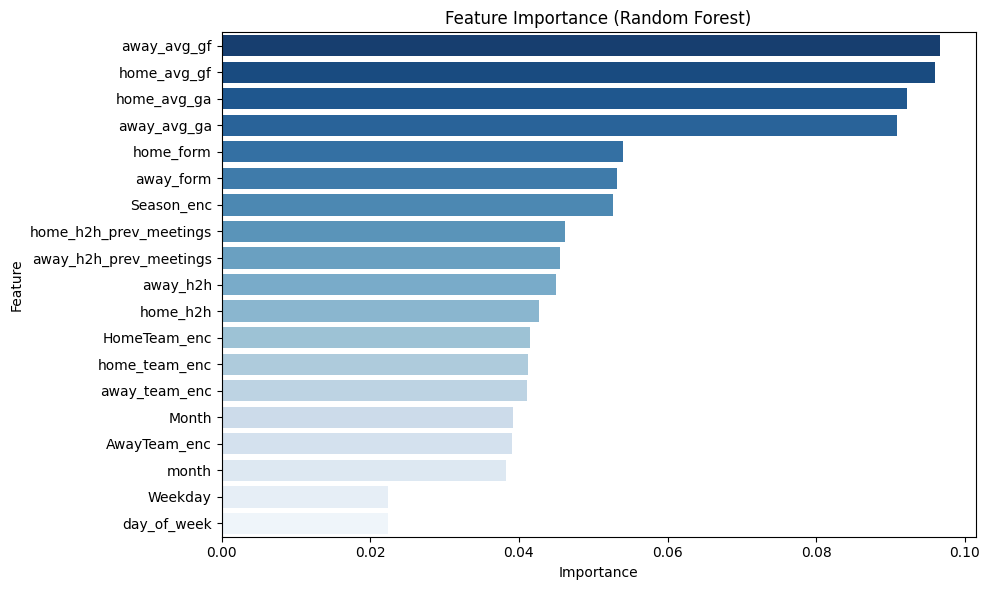

In [ ]:
# This shows which features were most important for the best model's predictions.
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_imp = feat_imp.sort_values('Importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='Blues_r')
    plt.title(f"Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()


<Figure size 500x500 with 0 Axes>

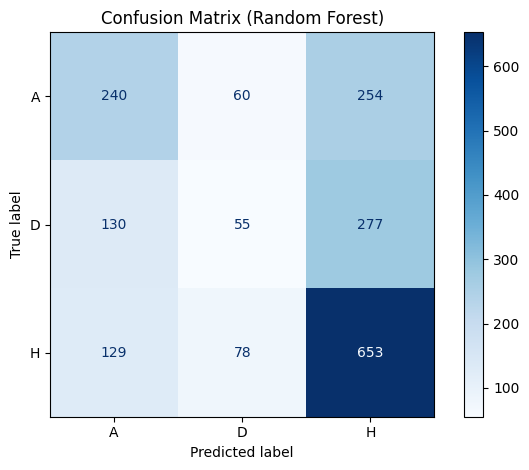

In [ ]:
# we'll plot the confusion matrix for the best model to see how well it distinguishes between classes.
cm = results[best_model_name]["cm"]
plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

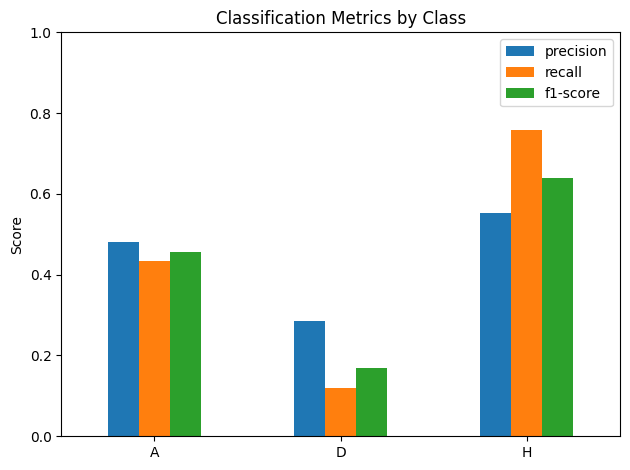

In [ ]:
# Let's make a classification report chart so you can easily see precision, recall, and f1 scores for each class.
report_data = classification_report(y_test, best_model.predict(X_test), output_dict=True, target_names=le.classes_)
report_df = pd.DataFrame(report_data).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
plt.figure(figsize=(8,5))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

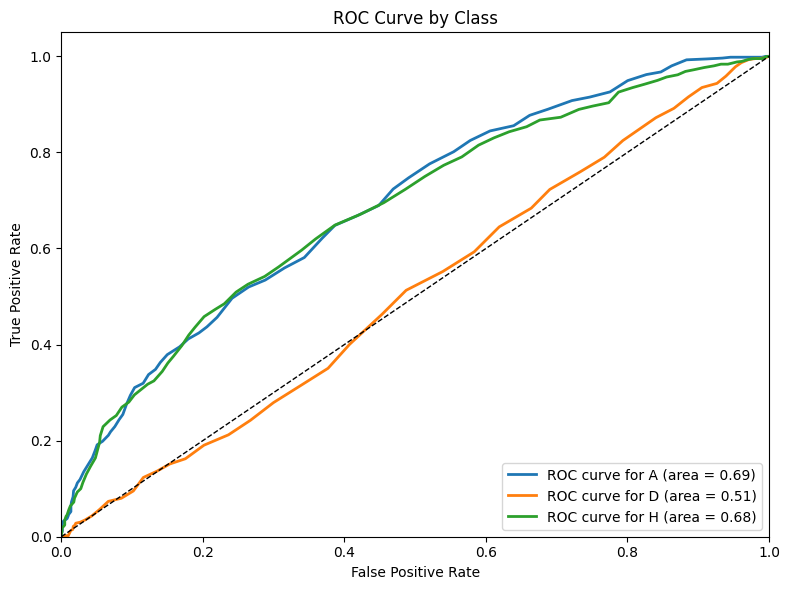

In [ ]:
# here's a ROC curve so you can visualize how well the best model separates the classes.
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=[0,1,2])
y_score = None
if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)
elif hasattr(best_model, "decision_function"):
    y_score = best_model.decision_function(X_test)
else:
    print("Best model doesn't support probability prediction for ROC curve.")

if y_score is not None:
    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve for {class_name} (area = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve by Class')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()